In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import pydata_google_auth
from utils.shuqing_all import *
plt.style.use('fivethirtyeight')
import joblib
five_thrity_eight=[
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",    
]
from sklearn.cluster import DBSCAN
!pip3 install umap-learn --quiet

In [33]:
SQL= """
SELECT  question.partner_position_id,
position_type,
title,
started_at,
is_active,
date,
question_id,
choice_ids,
feature_table.articles_unique_days_viewed_last_1m
,feature_table.customers_gathered_last_1m
,feature_table.avg_monthly_ri_earned_last_3m
,feature_table.days_logged_into_portal_last_1m
,feature_table.days_since_last_activity,
feature_table.jtc_applications_last_1m
,feature_table.learning_plans_started_last_1m
,feature_table.prospects_unique_days_viewed_last_1m
,times_successfully_supporting_last_1m
FROM `uw-data-models-prod.partner_dataform_models_position.partner_profiling_answers` question
LEFT JOIN 
(SELECT a.snapshot_date
,a.partner_position_id
,b.articles_unique_days_viewed_last_1m
,a.customers_gathered_last_1m
,c.avg_monthly_ri_earned_last_3m
,d.days_logged_into_portal_last_1m
,e.days_since_last_activity
,f.jtc_applications_last_1m 
,g.learning_plans_started_last_1m
,h.is_live
,i.prospects_unique_days_viewed_last_1m
,j.times_successfully_supporting_last_1m
FROM `uw-data-models-prod.partner_dataform_models_feature_catalogue.customers_gathered_last_period` a
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.articles_unique_days_viewed_last_period`b
ON a.snapshot_date = b.snapshot_date AND a.partner_position_id = b.partner_position_id
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.avg_monthly_ri_earned_last_period` c
ON b.snapshot_date =c.snapshot_date AND c.partner_position_id = b.partner_position_id
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.days_logged_into_portal_last_period` d
ON c.snapshot_date = d.snapshot_date AND c.partner_position_id = d.partner_position_id
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.days_since_last_activity` e
ON d.snapshot_date = e.snapshot_date AND d.partner_position_id = e.partner_position_id
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.jtc_applications_last_period` f
ON e.snapshot_date = f.snapshot_date AND f.partner_position_id = e.partner_position_id
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.learning_plans_started_last_period` g
ON f.snapshot_date = g.snapshot_date AND f.partner_position_id = g.partner_position_id
LEFT JOIN  `uw-data-models-prod.partner_dataform_models_feature_catalogue.prospects_unique_days_viewed_last_period` i
ON i.snapshot_date = g.snapshot_date AND i.partner_position_id = g.partner_position_id
LEFT JOIN  `uw-data-models-prod.partner_dataform_models_feature_catalogue.times_successfully_supporting_last_period`  j
ON j.snapshot_date = i.snapshot_date AND j.partner_position_id = i.partner_position_id

LEFT JOIN (
SELECT snapshot_date
,partner_position_id
,is_live
FROM 
(SELECT partner_position_id
,snapshot_date
,is_live
,ROW_NUMBER() OVER (PARTITION BY partner_position_id ORDER BY snapshot_date DESC) num
FROM `uw-data-models-prod.partner_dataform_models_feature_catalogue.partner_position_live` 
# WHERE partner_position_id = '668079'
) tmp
WHERE tmp.num =1 
) h
ON  a.partner_position_id = h.partner_position_id          # '2021-06-10'
WHERE is_live = true AND a.snapshot_date = '2021-08-04'
ORDER BY snapshot_date DESC ) feature_table
ON question.partner_position_id = feature_table.partner_position_id


"""

In [43]:
all_live = """
SELECT 
a.partner_position_id
,tmp.*
FROM `uw-data-models-prod.partner_dataform_models_feature_catalogue.partner_position_live` a
LEFT JOIN (
SELECT a.snapshot_date
,a.partner_position_id as partner_id
,b.articles_unique_days_viewed_last_1m
,a.customers_gathered_last_1m
,c.avg_monthly_ri_earned_last_3m
,d.days_logged_into_portal_last_1m
,d.days_logged_into_portal_last_3m
,e.days_since_last_activity
,f.jtc_applications_last_1m
,f.jtc_applications_last_3m
,g.learning_plans_started_last_1m
,i.prospects_unique_days_viewed_last_1m
,j.times_successfully_supporting_last_1m
FROM `uw-data-models-prod.partner_dataform_models_feature_catalogue.customers_gathered_last_period` a
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.articles_unique_days_viewed_last_period`b
ON a.snapshot_date = b.snapshot_date AND a.partner_position_id = b.partner_position_id
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.avg_monthly_ri_earned_last_period` c
ON b.snapshot_date =c.snapshot_date AND c.partner_position_id = b.partner_position_id
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.days_logged_into_portal_last_period` d
ON c.snapshot_date = d.snapshot_date AND c.partner_position_id = d.partner_position_id
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.days_since_last_activity` e
ON d.snapshot_date = e.snapshot_date AND d.partner_position_id = e.partner_position_id
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.jtc_applications_last_period` f
ON e.snapshot_date = f.snapshot_date AND f.partner_position_id = e.partner_position_id
LEFT JOIN `uw-data-models-prod.partner_dataform_models_feature_catalogue.learning_plans_started_last_period` g
ON f.snapshot_date = g.snapshot_date AND f.partner_position_id = g.partner_position_id
LEFT JOIN  `uw-data-models-prod.partner_dataform_models_feature_catalogue.prospects_unique_days_viewed_last_period` i
ON i.snapshot_date = g.snapshot_date AND i.partner_position_id = g.partner_position_id
LEFT JOIN  `uw-data-models-prod.partner_dataform_models_feature_catalogue.times_successfully_supporting_last_period`  j
ON j.snapshot_date = i.snapshot_date AND j.partner_position_id = i.partner_position_id
) AS tmp
ON a.partner_position_id = tmp.partner_id
AND a.snapshot_date = tmp.snapshot_date
WHERE is_live = true
AND a.snapshot_date ='2021-08-01'



"""

In [35]:
rfm_q="""
SELECT * FROM `uw-data-models-prod.partner_dataform_models_position.rfm_score`

"""

In [36]:
df=download_data('uw-data-warehouse-prod',sign='<',time_constraint="'2020-04-18'",query=SQL)

Downloading:   0%|          | 0/3608 [00:00<?, ?rows/s]

In [37]:
rfm=download_data('uw-data-warehouse-prod',query=rfm_q)

Downloading:   0%|          | 0/45805 [00:00<?, ?rows/s]

In [38]:
acorn=pd.read_csv('acorn_df.csv')

In [44]:
all_live_df=download_data('uw-data-warehouse-prod',query=all_live)

Downloading:   0%|          | 0/45785 [00:00<?, ?rows/s]

In [42]:
acorn['acorn_category'] = acorn['acorn_category'].astype(int)
acorn['acorn_type'] = acorn['acorn_type'].astype(int)
acorn_cat_labels = (acorn.loc[:, ['acorn_category', 'acorn_category_desc']]
 .drop_duplicates().sort_values('acorn_category')).acorn_category_desc.tolist()
acorn_type_labels = (acorn.loc[:, ['acorn_type', 'acorn_type_desc']]
 .drop_duplicates().sort_values('acorn_type')).acorn_type_desc.tolist()
actype = pd.api.types.CategoricalDtype(categories=acorn_type_labels)
accat = pd.api.types.CategoricalDtype(categories=acorn_cat_labels)
acorn['acorn_category_desc'] = acorn['acorn_category_desc'].astype(accat)
acorn['acorn_type_desc'] = acorn['acorn_type_desc'].astype(actype)

## Feature Engineering

In [45]:
idx_columns=['partner_position_id','position_type','title','articles_unique_days_viewed_last_1m', 'customers_gathered_last_1m',
       'avg_monthly_ri_earned_last_3m', 'days_logged_into_portal_last_1m',
       'days_since_last_activity', 'jtc_applications_last_1m',
       'learning_plans_started_last_1m',
       'prospects_unique_days_viewed_last_1m',
       'times_successfully_supporting_last_1m']
p=Preprocessing(df) ## instantiate the class to create the object
p.clean_df()
p.fill_null()
data=p.split_answers(idx_columns) ## calling the method on the object

In [46]:
cat_features=data.select_dtypes(include=['object']).columns.drop(['partner_position_id',
            'position_type','title'])
ordinals={'HOW_MANY_IN_HOUSEHOLD':['1_TO_2_PEOPLE','3_TO_4_PEOPLE','5_PLUS_PEOPLE'],
 'HOW_MUCH_MONTHLY_INCOME':['1_TO_500','500_TO_2500','2500_PLUS'],
'HOW_MUCH_TIME_TO_COMMIT':['1_TO_5_HOURS','5_TO_10_HOURS','10_TO_15_HOURS','15_PLUS_HOURS']         }

In [47]:
e=Encoding(data.iloc[:,12:])
cat_dicts,train=e.categorise_cat(ordinals,cat_features)

In [ ]:
# for c in cat_features:
#     cat_list=data[c].unique().tolist()
#     cat_api=pd.api.types.CategoricalDtype(categories=cat_list,ordered=True)
#     data[c]=data[c].astype(cat_api)
# cat_list=['1_TO_500','500_TO_2500','2500_PLUS']
# cat_api=pd.api.types.CategoricalDtype(categories=cat_list,ordered=True)
# data.HOW_MUCH_MONTHLY_INCOME=data.HOW_MUCH_MONTHLY_INCOME.astype(cat_api)
# cat_list=['1_TO_5_HOURS','5_TO_10_HOURS','10_TO_15_HOURS','15_PLUS_HOURS']
# cat_api=pd.api.types.CategoricalDtype(categories=cat_list,ordered=True)
# data.HOW_MUCH_TIME_TO_COMMIT=data.HOW_MUCH_TIME_TO_COMMIT.astype(cat_api)

In [48]:
data=sort_cat_label(data)

In [49]:
all_live_df.drop(['partner_id','snapshot_date'],axis=1,inplace=True)

## UMAP + Kmeans Clustering

In [50]:
umap=joblib.load('new_partners_umap_embedding_model')
kmeans=joblib.load('new_partners_kmeans_model')

In [51]:
umap_embedding=umap.transform(train)
umap_pred=kmeans.predict(umap_embedding)
data['umap_y_pred']=umap_pred

In [ ]:
plt.figure(figsize=(8,6))
k=3
sns.scatterplot(umap_embedding.iloc[:,0],umap_embedding.iloc[:,1],palette=sns.hls_palette(2,l=.4,s=.9),hue=all_embedding.type).set_title('New vs Established Partners Clusters Comparison')
plt.ylabel('')
plt.xlabel('')

In [ ]:
db=DBSCAN(eps=0.3,min_samples=10,n_jobs=-1)
cols=db.fit_predict(umap_embedding)
sns.scatterplot(umap_embedding[:,0],umap_embedding[:,1],c=cols,cmap='Accent')

### New vs Established Partners Clusters Comparison

In [96]:
new_partners_umap_embedding=pd.read_csv('new_partners_umap_embedding.csv')
new_partners_u_map_pred=pd.read_csv('new_partners_u_map_pred.csv')

In [97]:
a=umap_embedding
b=umap_pred
new_partners_umap_embedding=new_partners_umap_embedding.iloc[:,1:]
a=pd.DataFrame(a)
a.rename(columns={0:0,1:1},inplace=True)
new_partners_umap_embedding.rename(columns={'0':0,'1':1},inplace=True)
all_embedding=new_partners_umap_embedding.append(a)
all_embedding.loc[:len(new_partners_umap_embedding),'type']='new partners'
all_embedding.loc[len(new_partners_umap_embedding):,'type']='established partners'

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, '')

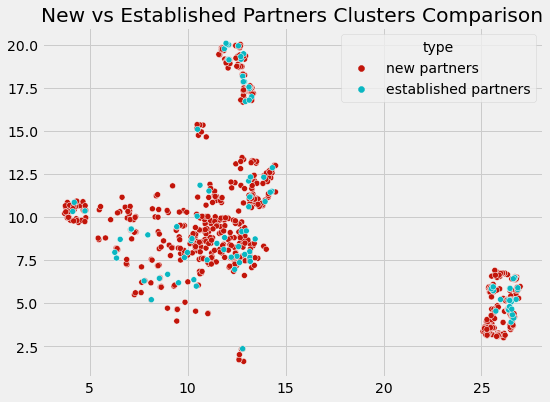

In [123]:
plt.figure(figsize=(8,6))
k=3
sns.scatterplot(all_embedding.iloc[:,0],all_embedding.iloc[:,1],palette=sns.hls_palette(2,l=.4,s=.9),hue=all_embedding.type).set_title('New vs Established Partners Clusters Comparison')
plt.ylabel('')
plt.xlabel('')

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, '')

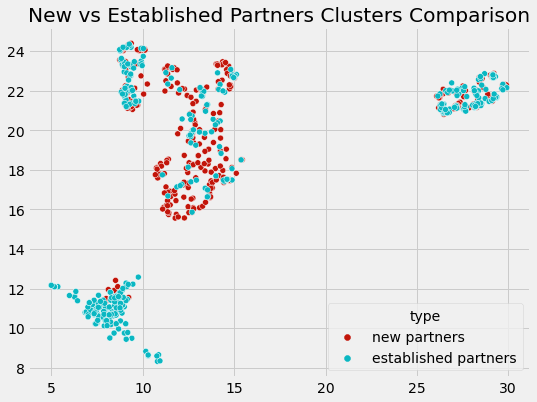

In [147]:
plt.figure(figsize=(8,6))
k=3
sns.scatterplot(all_embedding.iloc[:,0],all_embedding.iloc[:,1],palette=sns.hls_palette(2,l=.4,s=.9),hue=all_embedding.type).set_title('New vs Established Partners Clusters Comparison')
plt.ylabel('')
plt.xlabel('')

### UMmap + Kmeans Visualisation

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Umap with K-Means Labels')

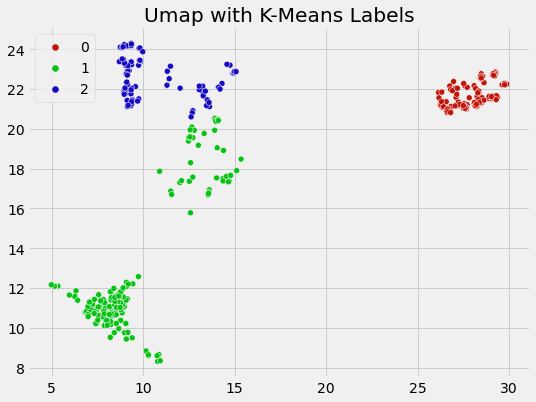

In [82]:
plt.figure(figsize=(8,6))
k=3
sns.scatterplot(umap_embedding[:,0],umap_embedding[:,1],
                palette=sns.hls_palette(k,l=.4,s=.9),hue=umap_pred).set_title('Umap with K-Means Labels')

In [150]:
data.umap_y_pred.value_counts()

1    255
0    122
2     71
Name: umap_y_pred, dtype: int64

In [83]:
data.umap_y_pred.value_counts()

1    221
0    121
2     97
Name: umap_y_pred, dtype: int64

In [93]:
pd.Series(umap_pred).to_pickle('umap_prediction_established_partners.pkl')
data.to_pickle('established_partners_umap_clustering.pkl')

In [12]:
y_pred=pd.read_pickle('umap_prediction_established_partners.pkl')
data['umap_y_pred']=y_pred

In [9]:
# data.loc[(data.articles_unique_days_viewed_last_1m>-0.001)&(data.articles_unique_days_viewed_last_1m<=6),'band_articles_unique_days_viewed_last_1m']='[0,6]'
# data.loc[(data.articles_unique_days_viewed_last_1m>6)&(data.articles_unique_days_viewed_last_1m<=10),'band_articles_unique_days_viewed_last_1m']='(6,10]'
# data.loc[(data.articles_unique_days_viewed_last_1m>10)&(data.articles_unique_days_viewed_last_1m<=14),'band_articles_unique_days_viewed_last_1m']='(10,14]'
# data.loc[(data.articles_unique_days_viewed_last_1m>14)&(data.articles_unique_days_viewed_last_1m<=31),'band_articles_unique_days_viewed_last_1m']='(14,31]'
# data.loc[(data.customers_gathered_last_1m>-0.001)&(data.customers_gathered_last_1m<=1),'band_customers_gathered_last_1m']='[0,1]'
# data.loc[(data.customers_gathered_last_1m>1)&(data.customers_gathered_last_1m<=13),'band_customers_gathered_last_1m']='(1,13]'
# data.loc[(data.avg_monthly_ri_earned_last_3m>-0.001)&(data.avg_monthly_ri_earned_last_3m<=56.95),'band_avg_monthly_ri_earned_last_3m']='[0,56.95]'
# data.loc[(data.avg_monthly_ri_earned_last_3m>56.95)&(data.avg_monthly_ri_earned_last_3m<=302.685),'band_avg_monthly_ri_earned_last_3m']='(56.95,302.685]'
# data.loc[(data.avg_monthly_ri_earned_last_3m>302.685)&(data.avg_monthly_ri_earned_last_3m<=40421.74),'band_avg_monthly_ri_earned_last_3m']='(302.685,40421.74]'
# data.loc[(data.days_logged_into_portal_last_1m>-0.001)&(data.days_logged_into_portal_last_1m<=24),'band_days_logged_into_portal_last_1m']='[0,24]'
# data.loc[(data.days_logged_into_portal_last_1m>24)&(data.days_logged_into_portal_last_1m<=31),'band_days_logged_into_portal_last_1m']='(24,31]'
# data.loc[(data.days_since_last_activity>-0.001)&(data.days_since_last_activity<=7),'band_days_since_last_activity']='[0,7]'
# data.loc[(data.days_since_last_activity>7)&(data.days_since_last_activity<=18),'band_days_since_last_activity']='(7,18]'
# data.loc[(data.days_since_last_activity>18)&(data.days_since_last_activity<=244),'band_days_since_last_activity']='(18,244]'
# data.loc[(data.jtc_applications_last_1m>-0.001)&(data.jtc_applications_last_1m<=4),'band_jtc_applications_last_1m']='[0,4]'
# data.loc[(data.jtc_applications_last_1m>4)&(data.jtc_applications_last_1m<=10),'band_jtc_applications_last_1m']='(4,10]'
# data.loc[(data.jtc_applications_last_1m>10)&(data.jtc_applications_last_1m<=72),'band_jtc_applications_last_1m']='(10,72]'
# data.loc[(data.prospects_unique_days_viewed_last_1m>-0.001)&(data.prospects_unique_days_viewed_last_1m<=3),'band_prospects_unique_days_viewed_last_1m']='[0,3]'
# data.loc[(data.prospects_unique_days_viewed_last_1m>3)&(data.prospects_unique_days_viewed_last_1m<=7),'band_prospects_unique_days_viewed_last_1m']='(3,7]'
# data.loc[(data.prospects_unique_days_viewed_last_1m>7)&(data.prospects_unique_days_viewed_last_1m<=29),'band_prospects_unique_days_viewed_last_1m']='(7,29]'
# data.loc[(data.times_successfully_supporting_last_1m==0),'band_times_successfully_supporting_last_1m']='0'
# data.loc[(data.times_successfully_supporting_last_1m>0)&(data.times_successfully_supporting_last_1m<=3),'band_times_successfully_supporting_last_1m']='[1,3]'
# data.loc[(data.times_successfully_supporting_last_1m>3),'band_times_successfully_supporting_last_1m']='[4+]'

In [151]:
question_columns=['learning_plans_started_last_1m',
               'HOW_MANY_IN_HOUSEHOLD',
       'HOW_MUCH_MONTHLY_INCOME', 'HOW_MUCH_TIME_TO_COMMIT',
       'SPEND_MONTHLY_INCOME_ANSWER_DEBT',
       'SPEND_MONTHLY_INCOME_ANSWER_EDUCATION',
       'SPEND_MONTHLY_INCOME_ANSWER_HOLIDAY',
       'SPEND_MONTHLY_INCOME_ANSWER_INCOME',
       'SPEND_MONTHLY_INCOME_ANSWER_OTHER', 'total_spend_monthly_income_answer_count' ]

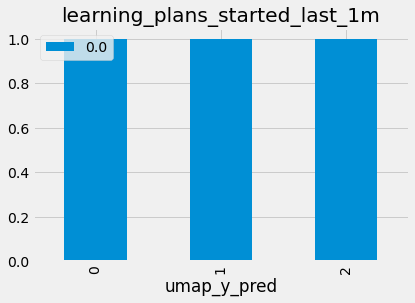

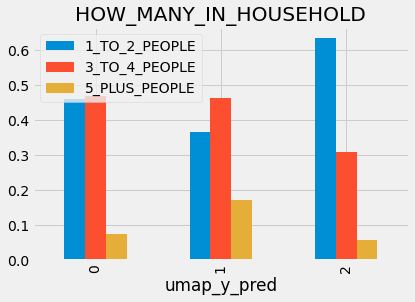

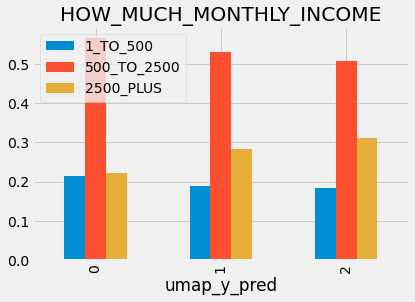

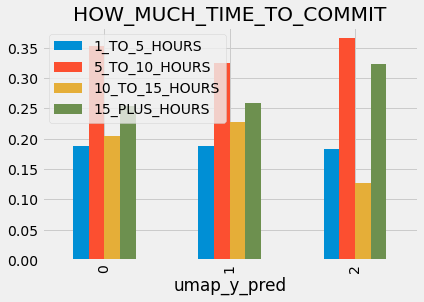

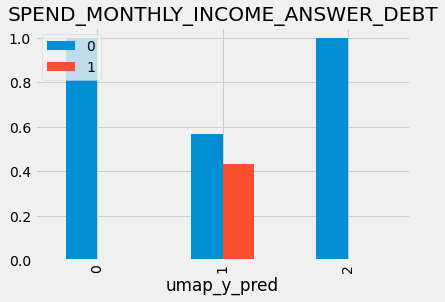

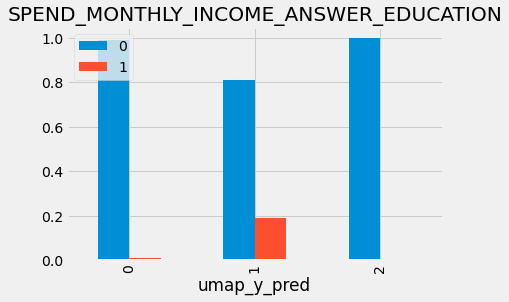

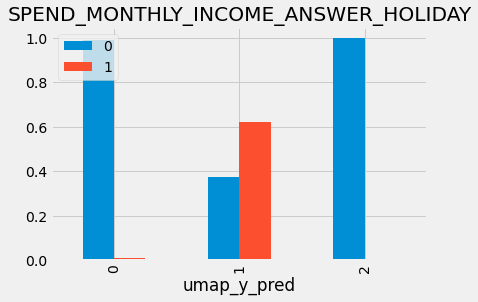

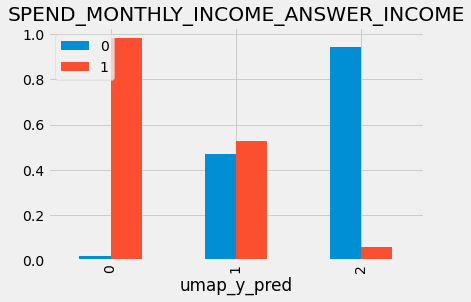

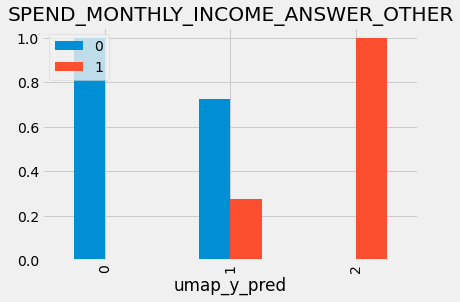

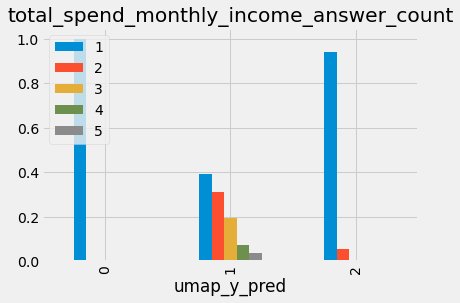

In [152]:
plt.style.use('fivethirtyeight')
five_thrity_eight=[
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",    
]
plot_columns(data,question_columns,'umap_y_pred')

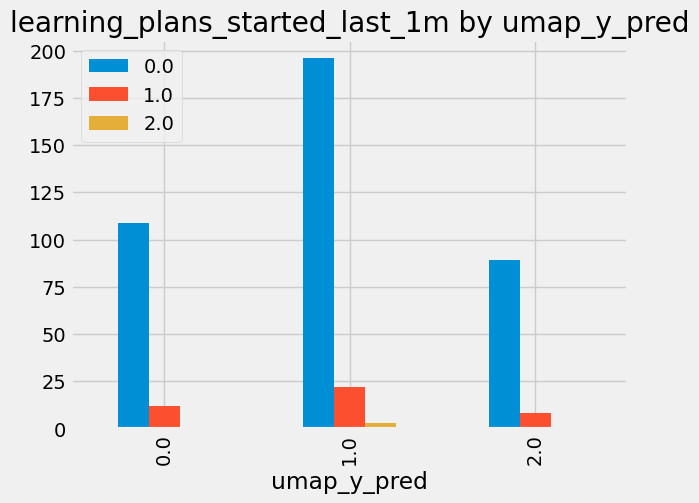

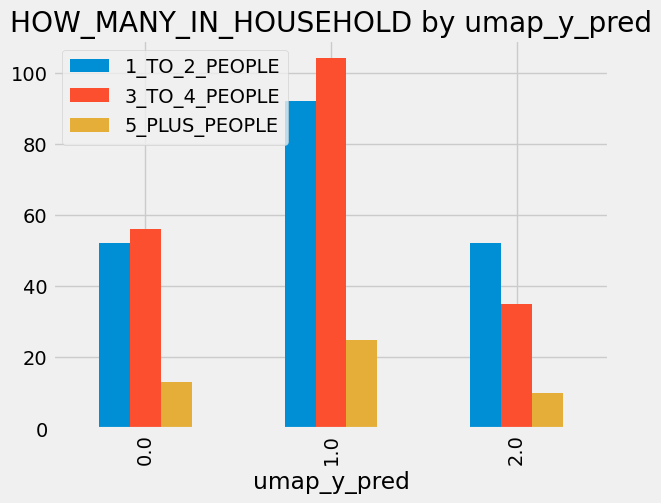

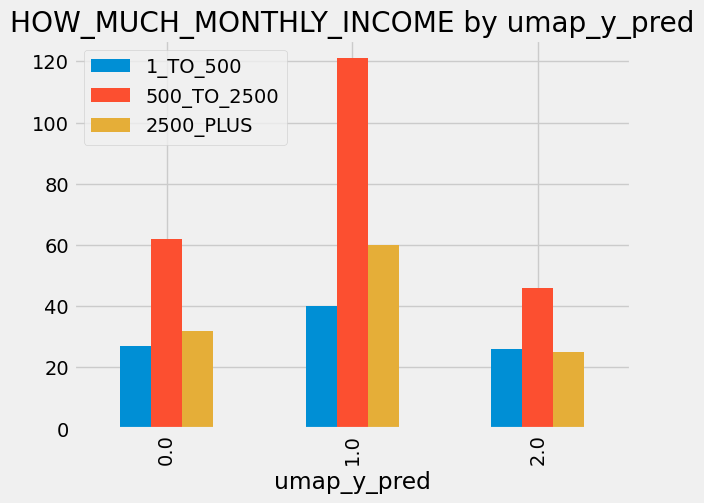

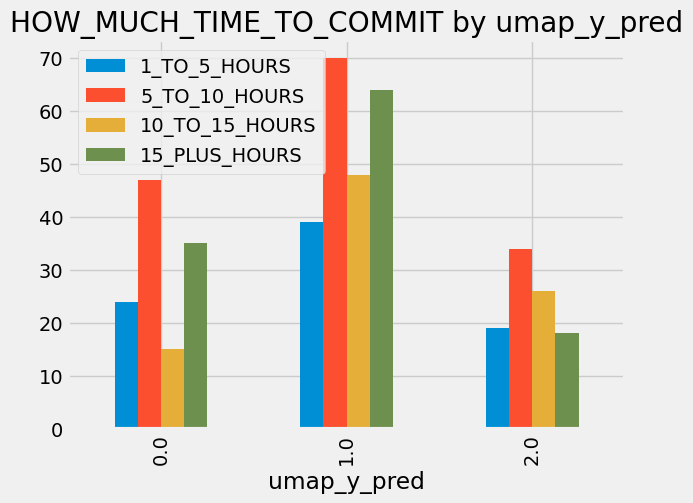

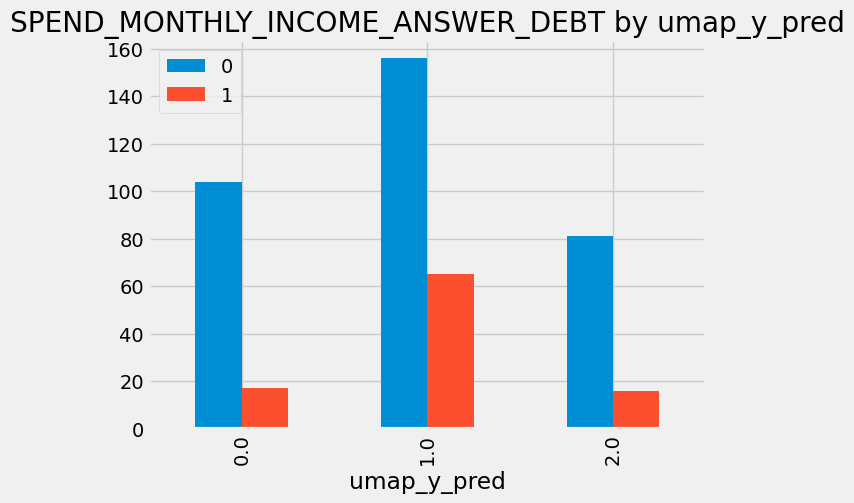

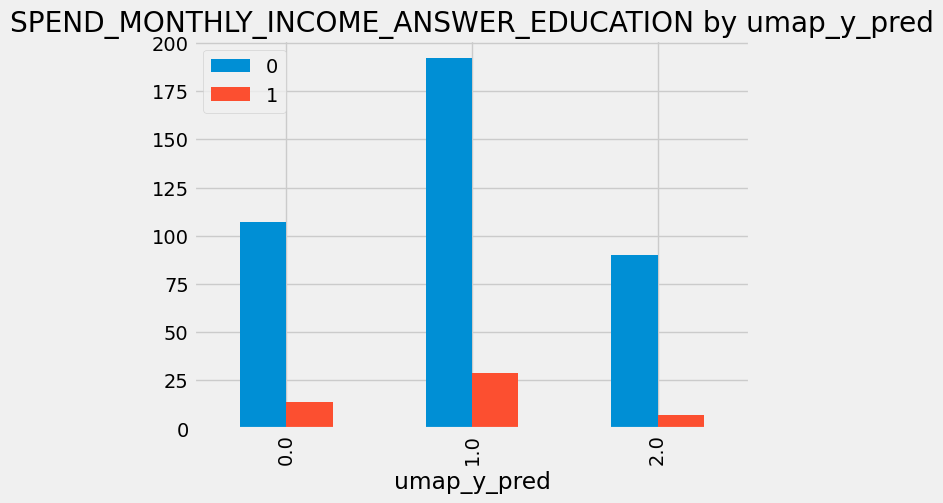

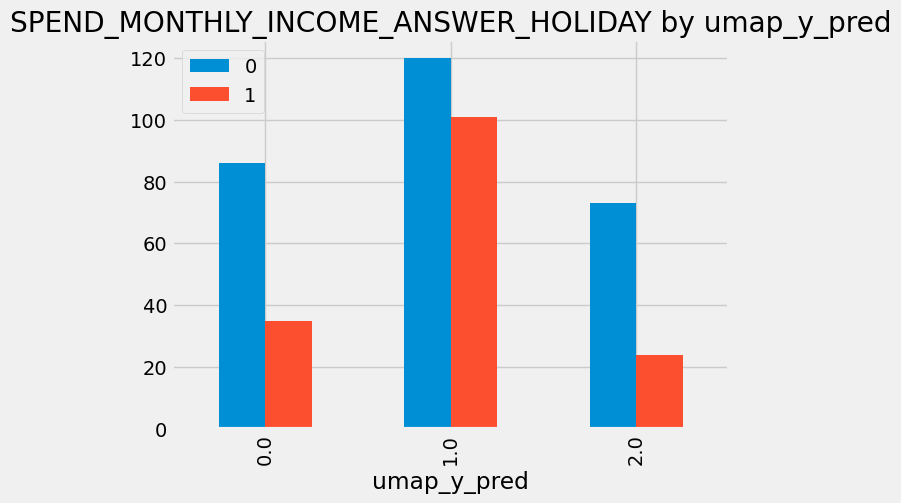

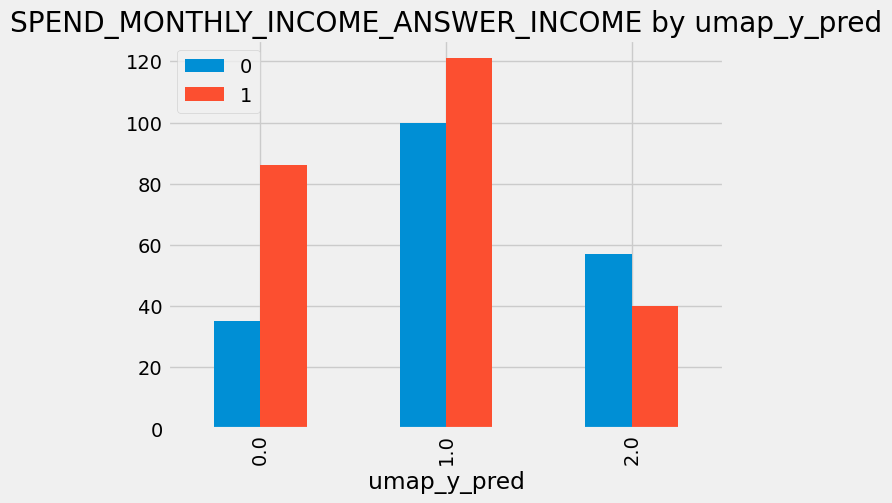

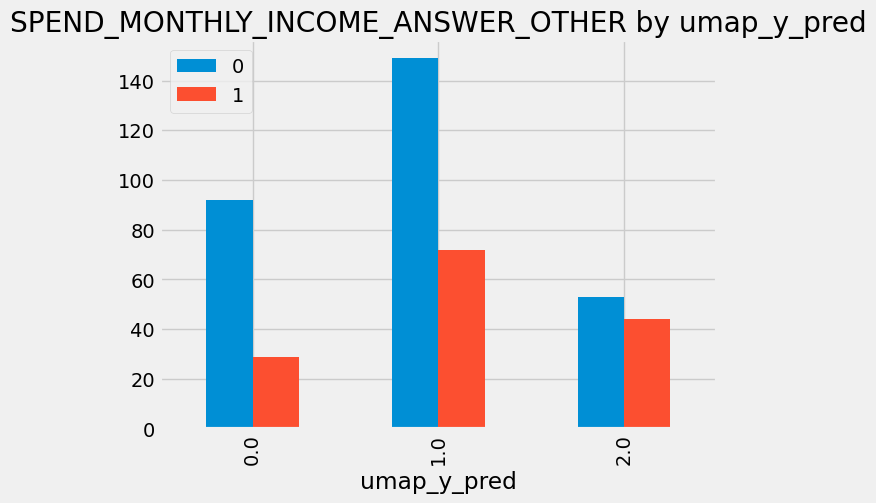

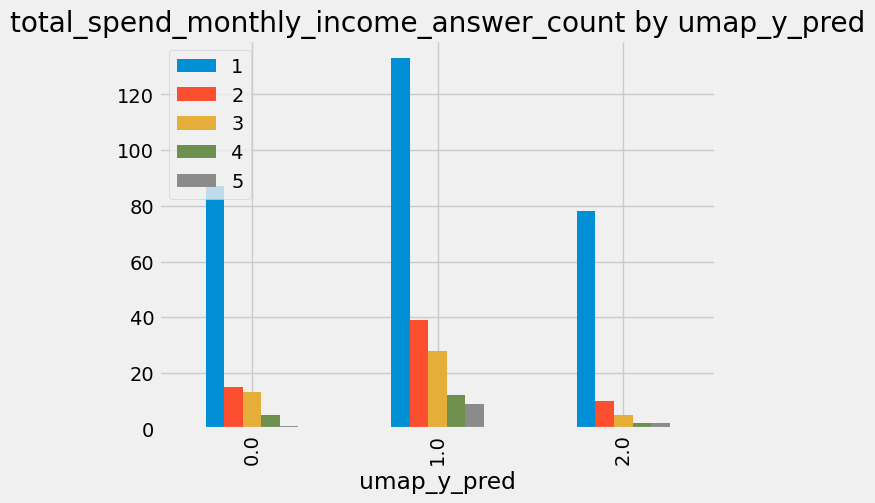

In [418]:
plt.style.use('fivethirtyeight')
five_thrity_eight=[
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",    
]
plot_columns(data,question_columns,'umap_y_pred')

/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


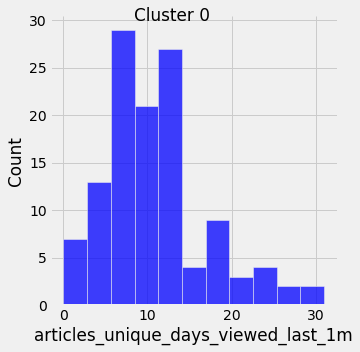

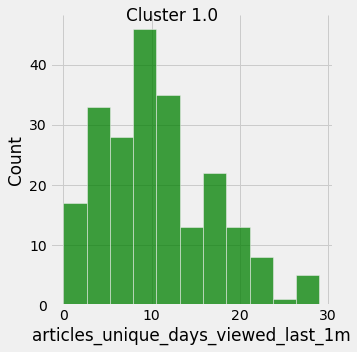

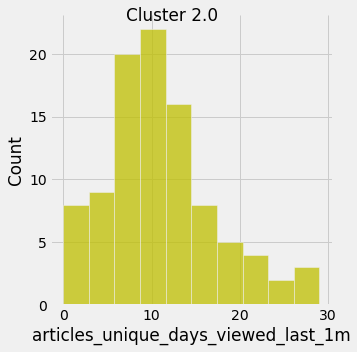

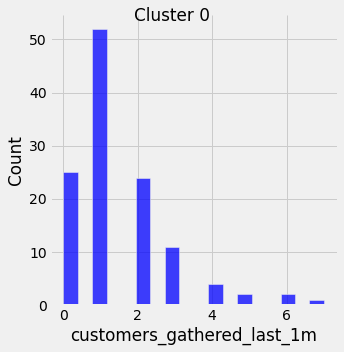

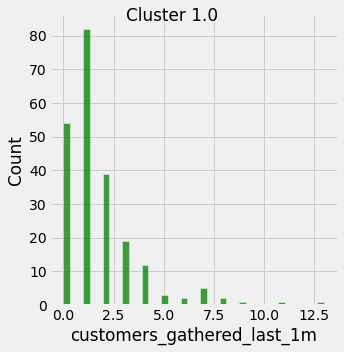

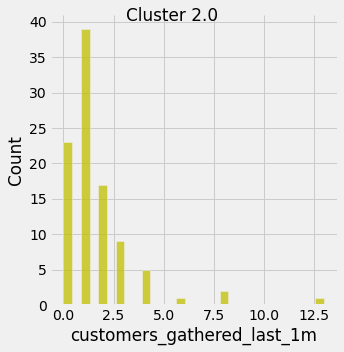

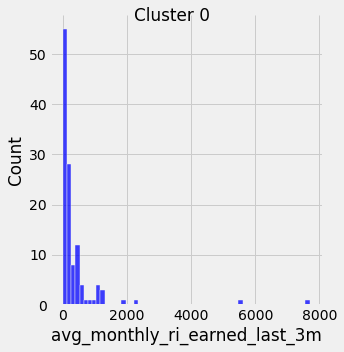

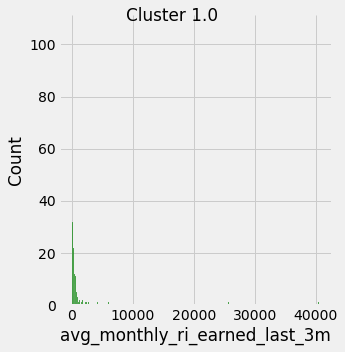

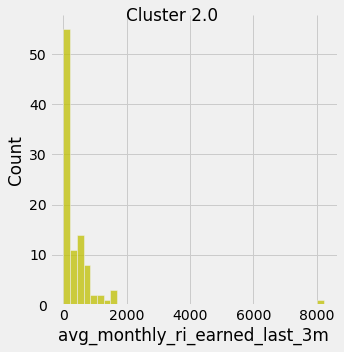

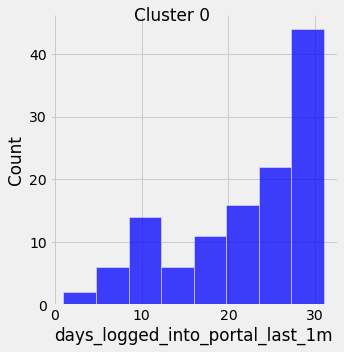

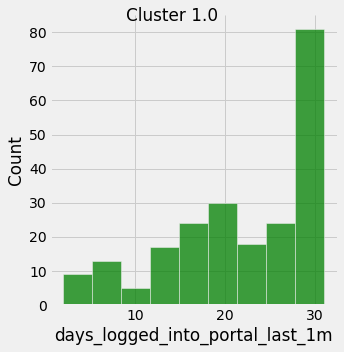

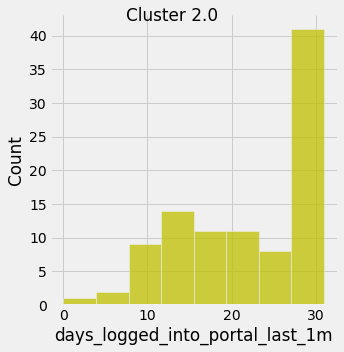

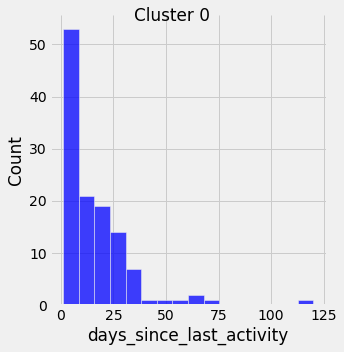

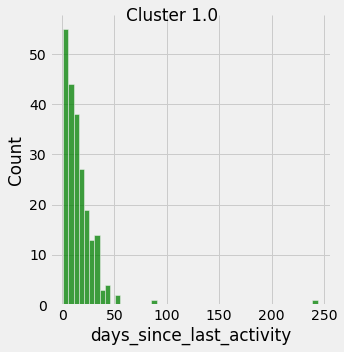

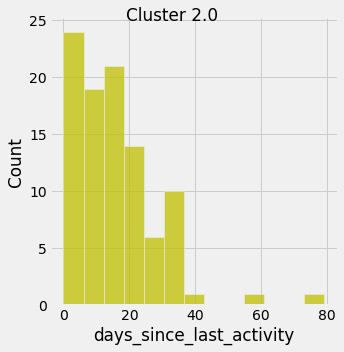

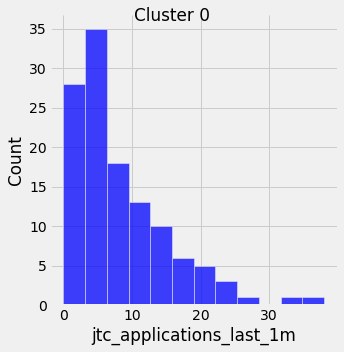

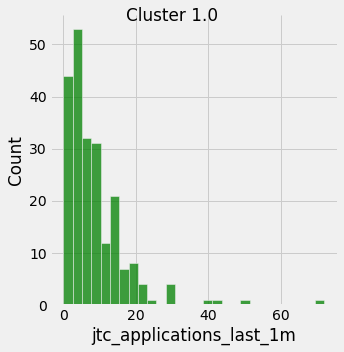

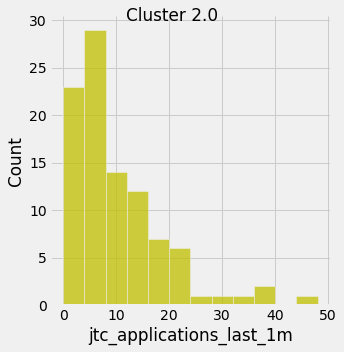

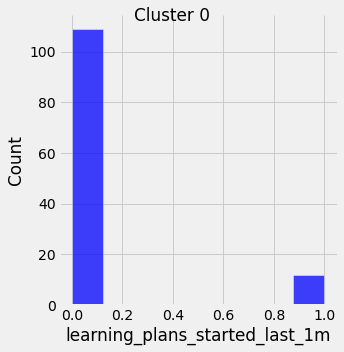

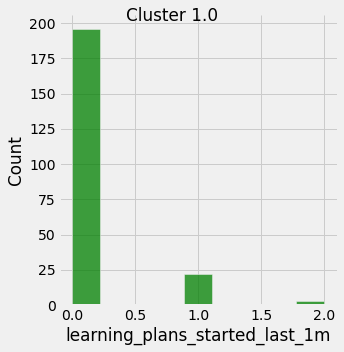

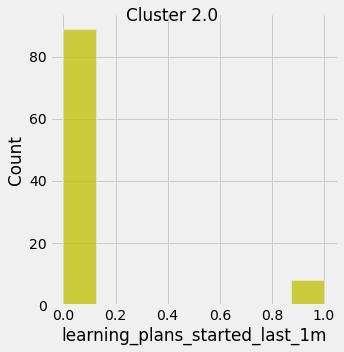

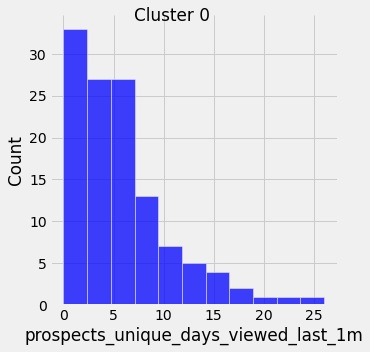

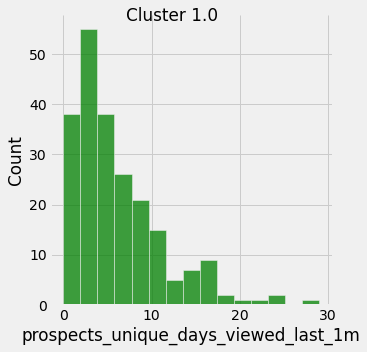

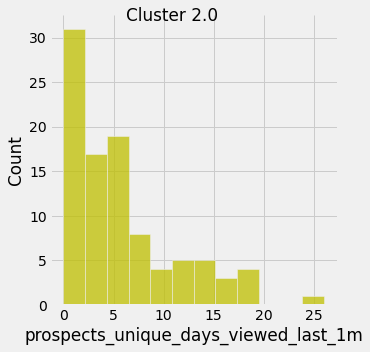

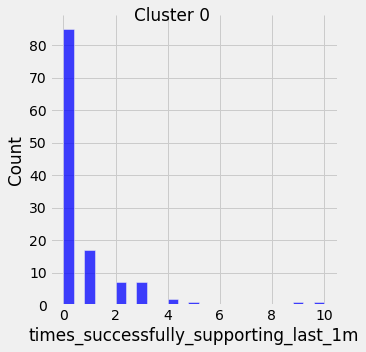

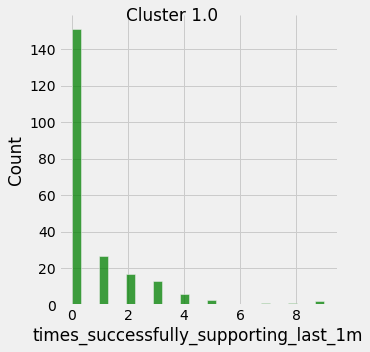

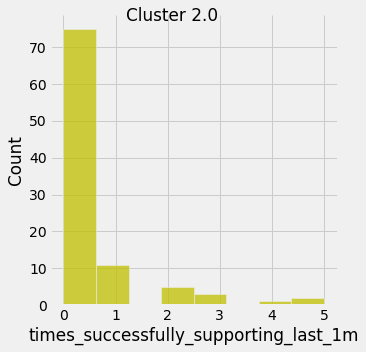

In [49]:
for c in ['articles_unique_days_viewed_last_1m', 'customers_gathered_last_1m',
       'avg_monthly_ri_earned_last_3m', 'days_logged_into_portal_last_1m',
       'days_since_last_activity', 'jtc_applications_last_1m',
       'learning_plans_started_last_1m',
       'prospects_unique_days_viewed_last_1m',
       'times_successfully_supporting_last_1m']:
    plot_dist(data,c)

In [14]:
for c in ['articles_unique_days_viewed_last_1m', 'customers_gathered_last_1m',
       'avg_monthly_ri_earned_last_3m', 'days_logged_into_portal_last_1m',
       'days_since_last_activity', 'jtc_applications_last_1m',
       'learning_plans_started_last_1m',
       'prospects_unique_days_viewed_last_1m',
       'times_successfully_supporting_last_1m']:
    remove_outliers(data,c)

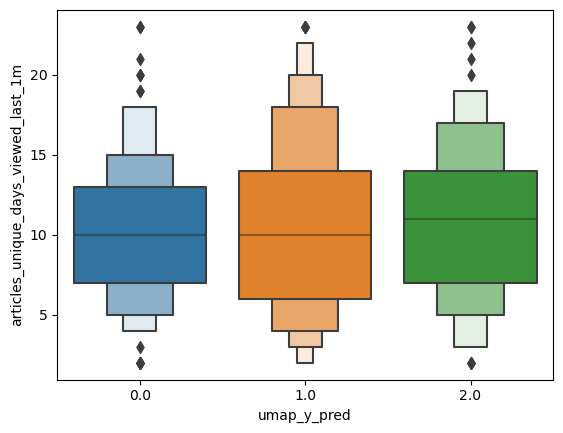

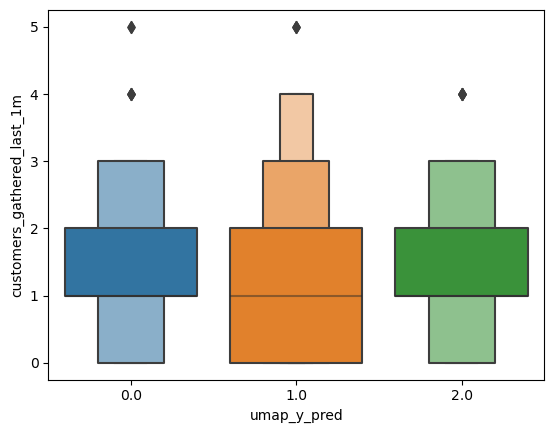

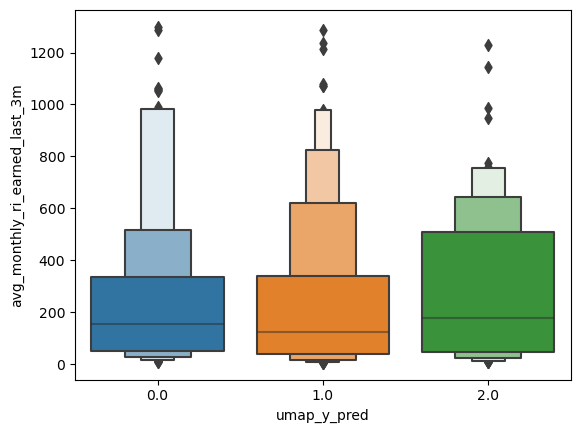

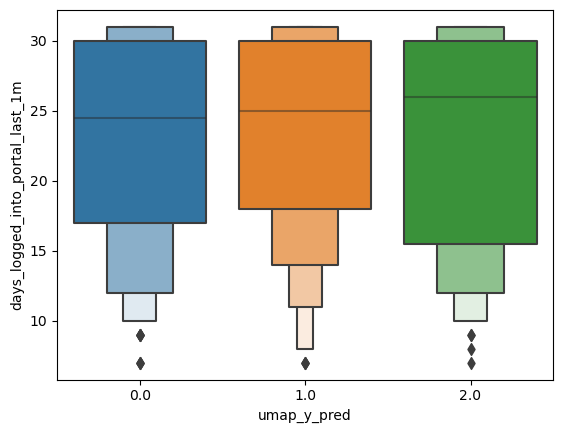

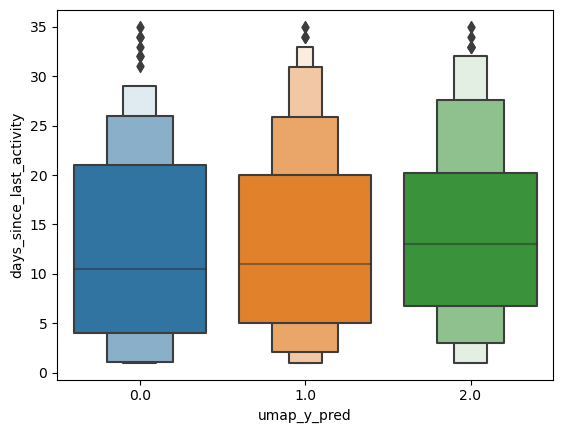

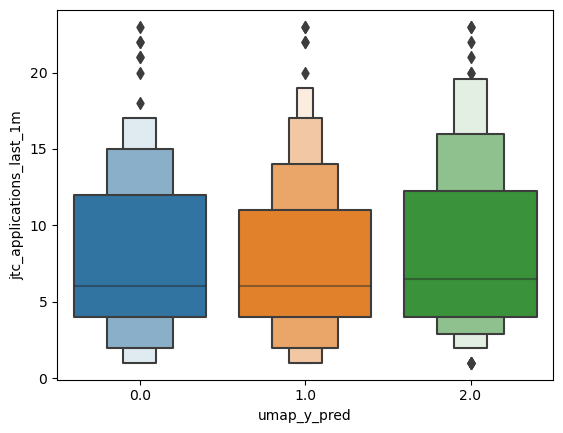

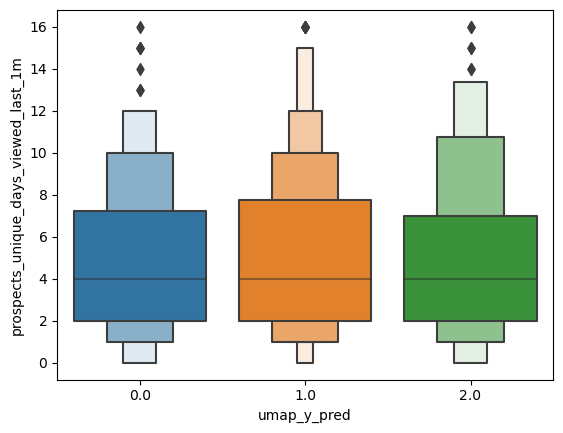

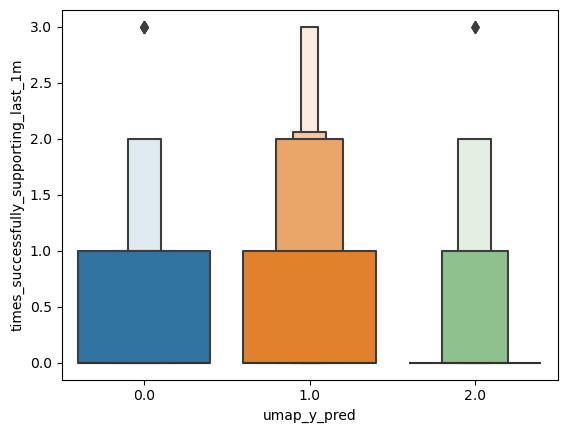

In [272]:
continuous_num_cols=['articles_unique_days_viewed_last_1m', 'customers_gathered_last_1m',
       'avg_monthly_ri_earned_last_3m', 'days_logged_into_portal_last_1m',
       'days_since_last_activity', 'jtc_applications_last_1m',
       'prospects_unique_days_viewed_last_1m',
       'times_successfully_supporting_last_1m']
for c in continuous_num_cols:
    plt.style.use('default')
    f,ax=plt.subplots()
    sns.boxenplot(y=data.loc[data[f'outliers_removed_{c}']==1,c],x=data.loc[data[f'outliers_removed_{c}']==1,'umap_y_pred'],ax=ax)

In [153]:
continuous_num_cols=['articles_unique_days_viewed_last_1m', 'customers_gathered_last_1m',
       'avg_monthly_ri_earned_last_3m', 'days_logged_into_portal_last_1m',
       'days_since_last_activity', 'jtc_applications_last_1m',
       'prospects_unique_days_viewed_last_1m',
       'times_successfully_supporting_last_1m']

stats=[]
for c in continuous_num_cols:
    c_mean,c_median=data.groupby(['umap_y_pred'])[c].mean(),data.groupby(['umap_y_pred'])[c].median()
    stats.append(c_mean)
    stats.append(c_median)
summary_stat=np.round(pd.DataFrame(stats),2)
summary_stat['stats_type']=['mean','median']*8
data['has_gathered_a_customer']= data.customers_gathered_last_1m>0
summary_stat=summary_stat.append(data.groupby(['umap_y_pred'])['has_gathered_a_customer'].mean())
summary_stat.fillna('mean',inplace=True)


In [154]:
summary_stat.round(2)

umap_y_pred,0,1,2,stats_type
articles_unique_days_viewed_last_1m,0.0,0.0,0.0,mean
articles_unique_days_viewed_last_1m,0.0,0.0,0.0,median
customers_gathered_last_1m,0.0,0.0,0.0,mean
customers_gathered_last_1m,0.0,0.0,0.0,median
avg_monthly_ri_earned_last_3m,0.0,0.0,0.0,mean
avg_monthly_ri_earned_last_3m,0.0,0.0,0.0,median
days_logged_into_portal_last_1m,0.0,0.0,0.0,mean
days_logged_into_portal_last_1m,0.0,0.0,0.0,median
days_since_last_activity,0.0,0.0,0.0,mean
days_since_last_activity,0.0,0.0,0.0,median


## Summary
- Group 0:more people geared towards lower end ri earned,proportionally more people dormant,more lower end income buckets, most willing to commit 5-10 hrs, least motivated  
- Group 1: long tail customer gathered last 1m n most active partners fall into this group, most outlier ri earned,most active in portal logging,most active in supporting last m,successfully supported 1 last 1m, higher proportion of 5+ household, higher income buckets, most willing to commit 15+ hrs, most mitivated   
- Group 2:proportionally more people viewed the most articles,proportionally most people have middle range ri earned,proportionally most active in jtc applications(5-15), 2nd active in prospects viewed 

In short, group 1 strong at materialising result driven actions (supporting others), group 2 slightly better than group 0 at result oriented actions (jtc applications). However for group 2, they need more impact direct actions such as more mentoring and supporting 

## Synthetic Clustering

In [156]:
umap_embedding=umap.transform(train)

In [157]:
established_partners_synthetic_clusters=synthetic_clusters(umap_embedding)

In [158]:
data['synthetic_clusters']=established_partners_synthetic_clusters.cluster

In [159]:
data.synthetic_clusters.value_counts()

1    255
0    122
2     71
Name: synthetic_clusters, dtype: int64

In [19]:
data.synthetic_clusters.value_counts()

1    172
2    132
0    111
Name: synthetic_clusters, dtype: int64

In [27]:
data.columns

Index(['partner_position_id', 'position_type', 'title',
       'articles_unique_days_viewed_last_1m', 'customers_gathered_last_1m',
       'avg_monthly_ri_earned_last_3m', 'days_logged_into_portal_last_1m',
       'days_since_last_activity', 'jtc_applications_last_1m',
       'learning_plans_started_last_1m',
       'prospects_unique_days_viewed_last_1m',
       'times_successfully_supporting_last_1m', 'HOW_MANY_IN_HOUSEHOLD',
       'HOW_MUCH_MONTHLY_INCOME', 'HOW_MUCH_TIME_TO_COMMIT',
       'SPEND_MONTHLY_INCOME_ANSWER_DEBT',
       'SPEND_MONTHLY_INCOME_ANSWER_EDUCATION',
       'SPEND_MONTHLY_INCOME_ANSWER_HOLIDAY',
       'SPEND_MONTHLY_INCOME_ANSWER_INCOME',
       'SPEND_MONTHLY_INCOME_ANSWER_OTHER',
       'total_spend_monthly_income_answer_count', 'synthetic_clusters'],
      dtype='object', name='question_id')

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '')

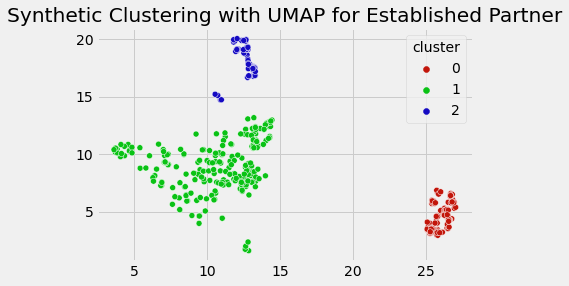

In [160]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(6,4))
sns.scatterplot(established_partners_synthetic_clusters.iloc[:,0],established_partners_synthetic_clusters.iloc[:,1],
                palette=sns.hls_palette(established_partners_synthetic_clusters.cluster.nunique(),l=.4,s=.9),hue=established_partners_synthetic_clusters.cluster).set_title('Synthetic Clustering with UMAP for Established Partner')
plt.xlabel('')
plt.ylabel('')

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '')

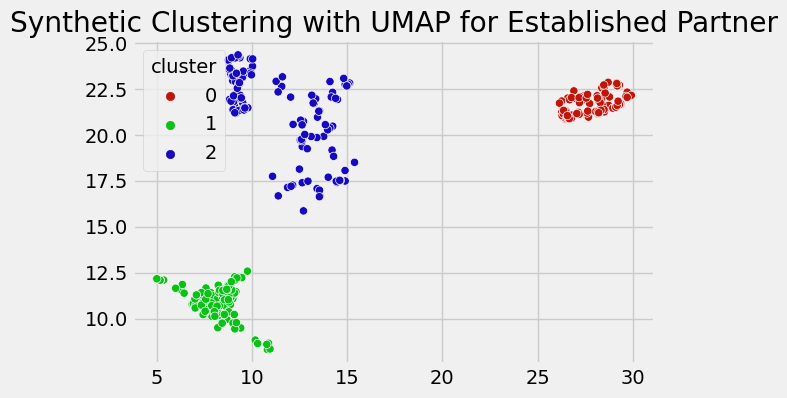

In [210]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(6,4))
sns.scatterplot(established_partners_synthetic_clusters.iloc[:,0],established_partners_synthetic_clusters.iloc[:,1],
                palette=sns.hls_palette(3,l=.4,s=.9),hue=established_partners_synthetic_clusters.cluster).set_title('Synthetic Clustering with UMAP for Established Partner')
plt.xlabel('')
plt.ylabel('')

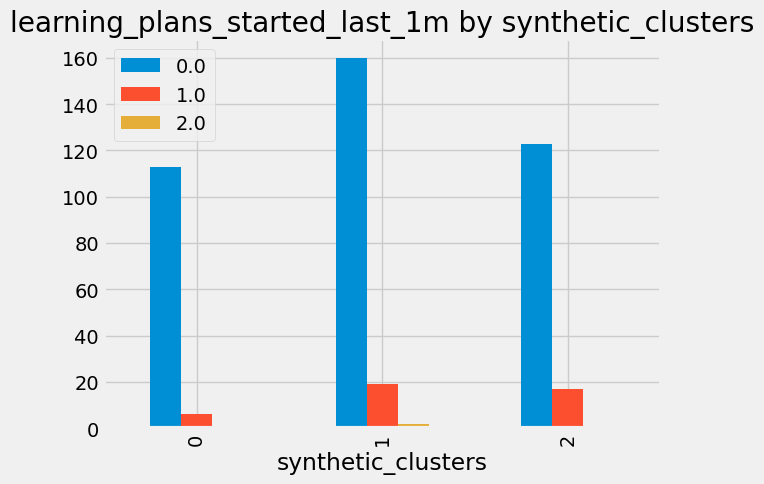

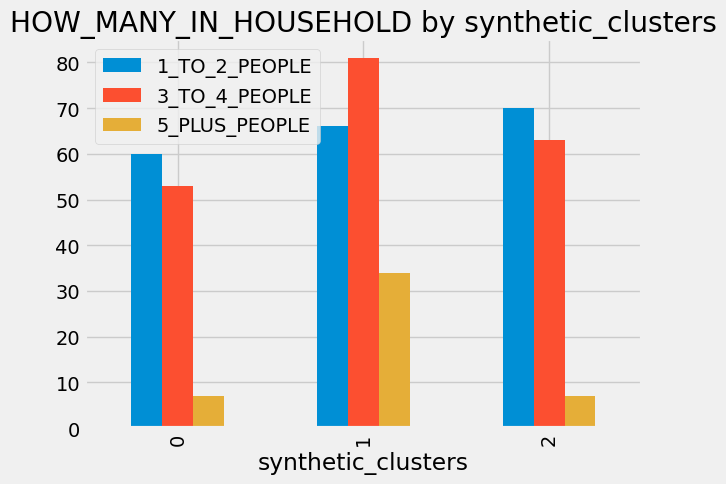

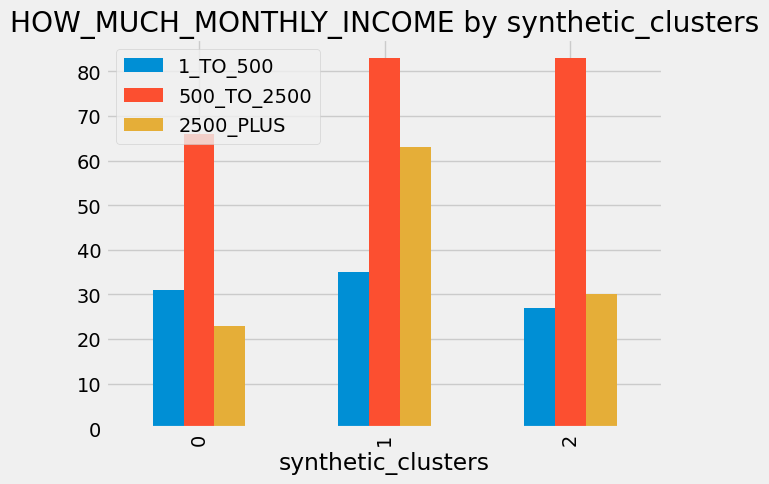

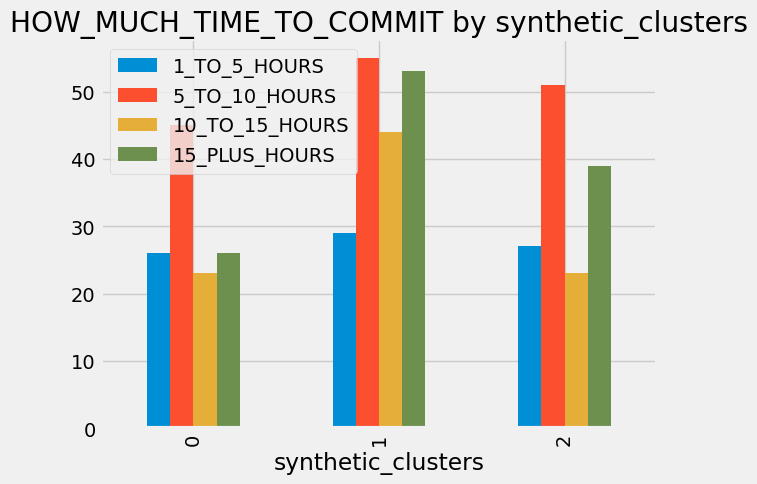

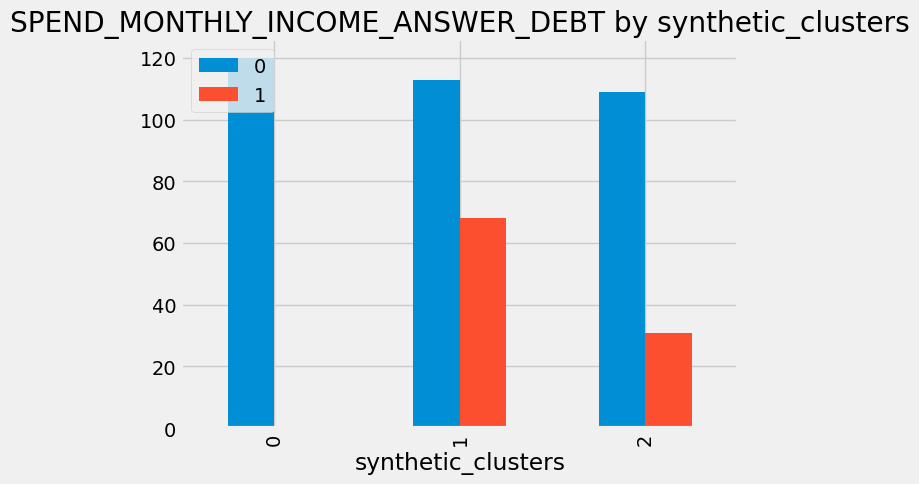

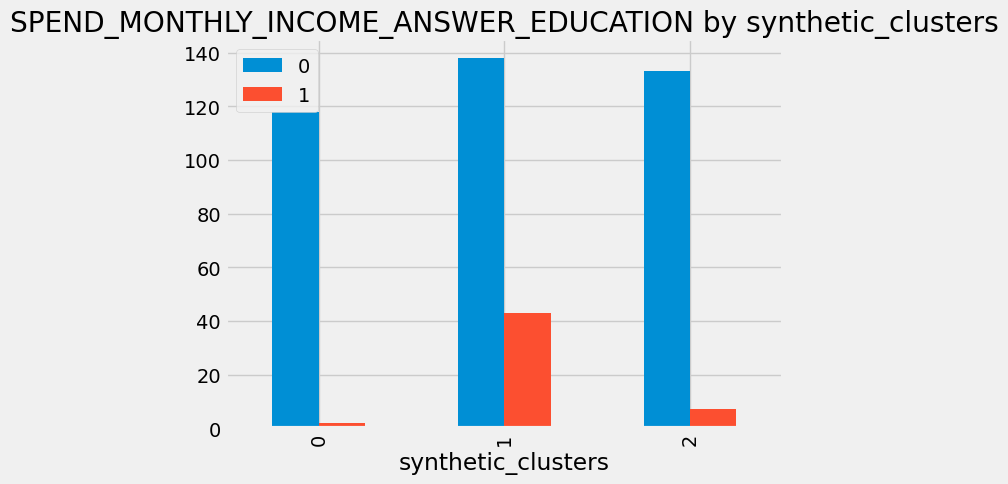

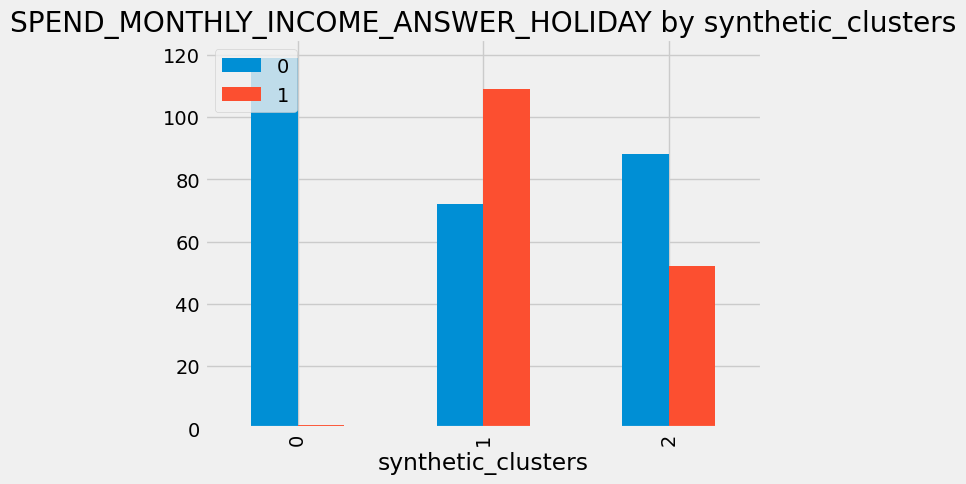

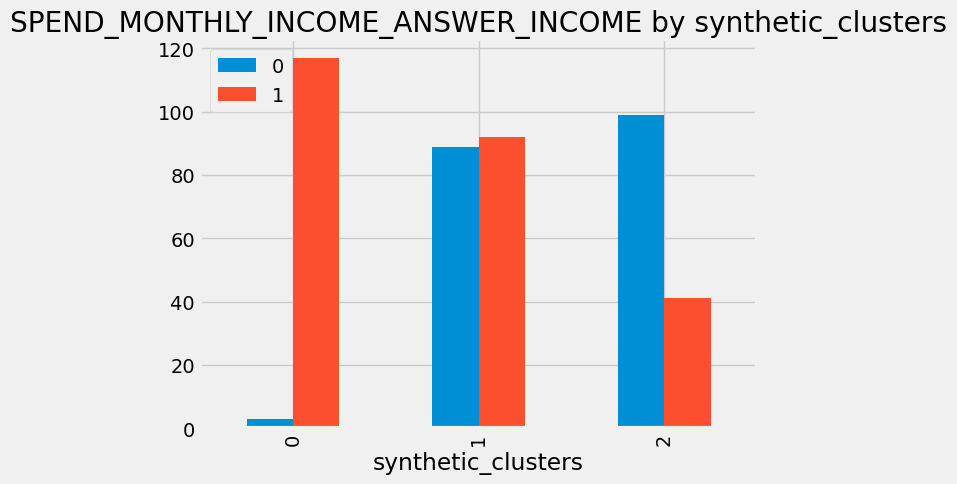

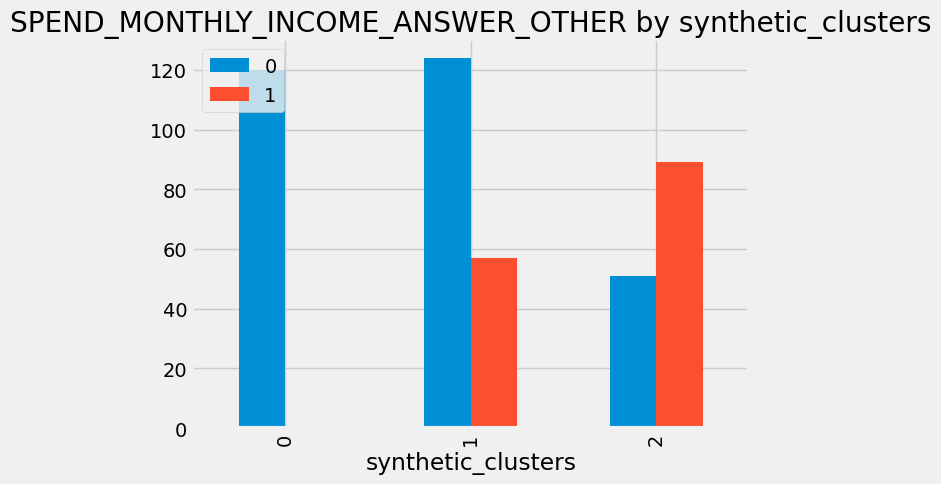

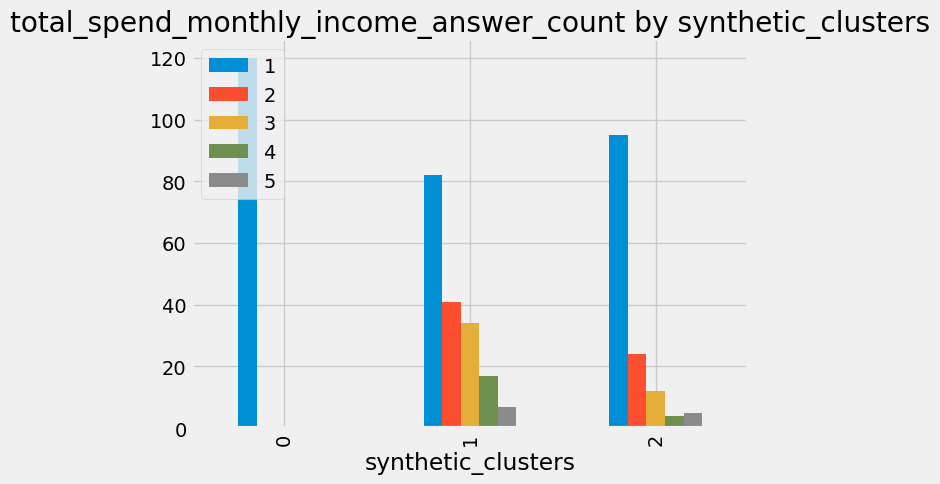

In [212]:
plt.style.use('fivethirtyeight')
plot_columns(data,question_columns,'synthetic_clusters')

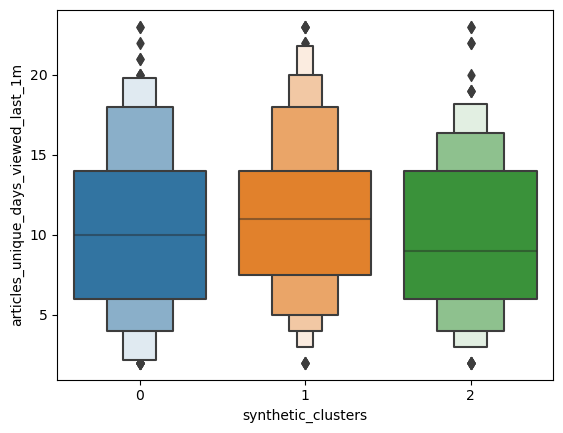

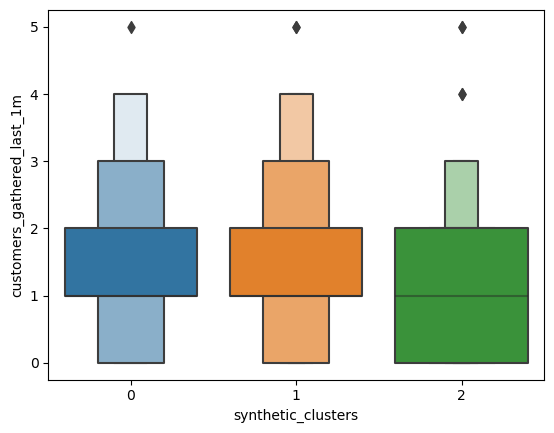

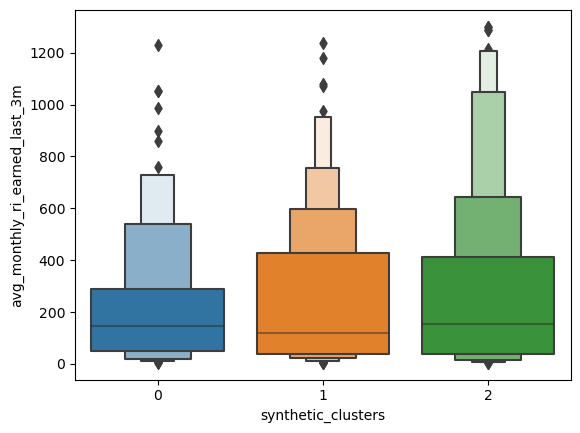

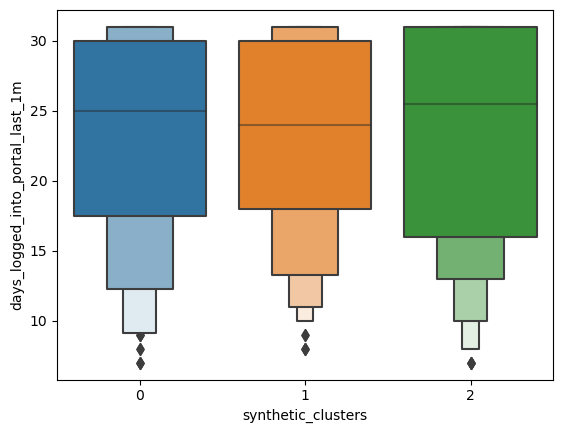

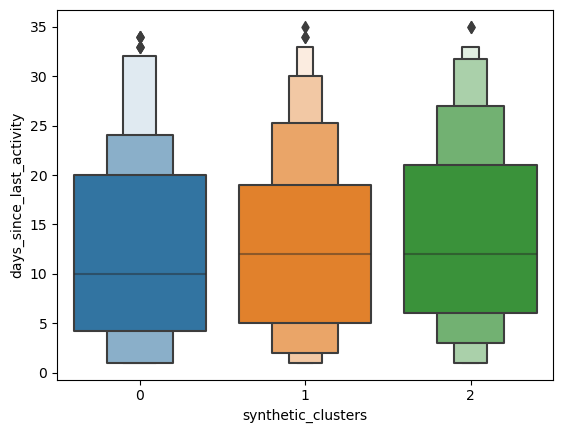

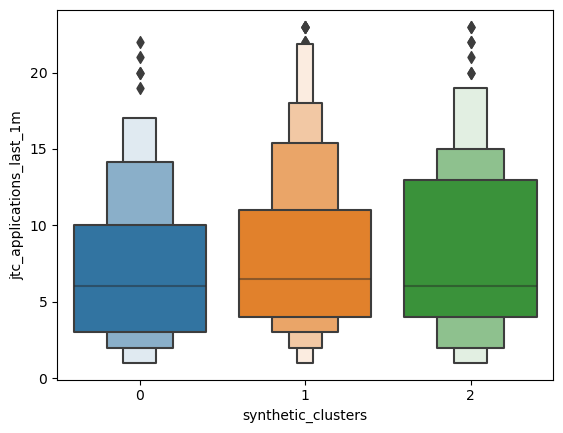

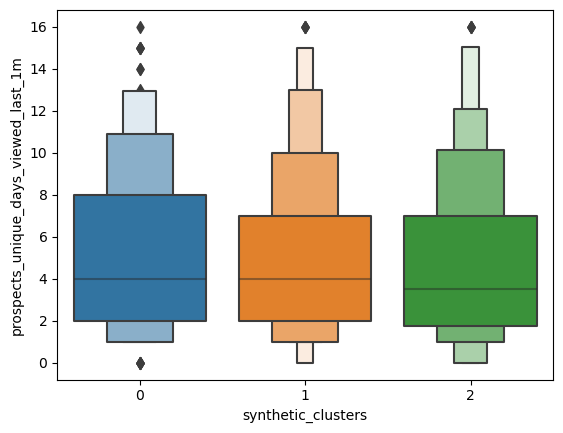

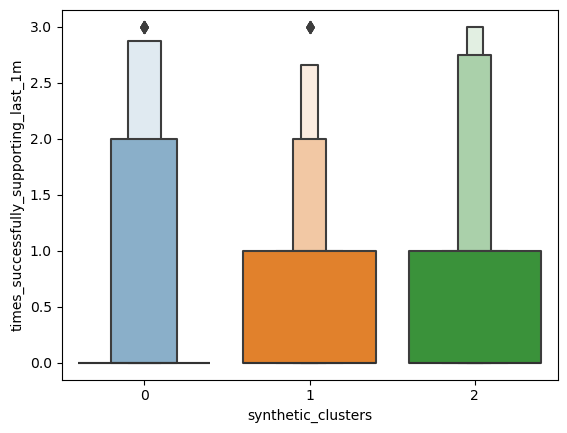

In [213]:
for c in continuous_num_cols:
    plt.style.use('default')
    f,ax=plt.subplots()
    sns.boxenplot(y=data.loc[data[f'outliers_removed_{c}']==1,c],x=data.loc[data[f'outliers_removed_{c}']==1,'synthetic_clusters'],ax=ax)

In [214]:
stats=[]
for c in continuous_num_cols:
    c_mean,c_median=data.groupby(['synthetic_clusters'])[c].mean(),data.groupby(['synthetic_clusters'])[c].median()
    stats.append(c_mean)
    stats.append(c_median)
summary_stat=np.round(pd.DataFrame(stats),2)
summary_stat['stats_type']=['mean','median']*8
data['has_gathered_a_customer']= data.customers_gathered_last_1m>0
summary_stat=summary_stat.append(data.groupby(['synthetic_clusters'])['has_gathered_a_customer'].mean())
summary_stat.fillna('mean',inplace=True)

In [216]:
summary_stat.round(2)

synthetic_clusters,0,1,2,stats_type
articles_unique_days_viewed_last_1m,10.27,11.10,10.86,mean
articles_unique_days_viewed_last_1m,10.00,11.00,9.00,median
customers_gathered_last_1m,1.72,1.59,1.57,mean
customers_gathered_last_1m,1.00,1.00,1.00,median
avg_monthly_ri_earned_last_3m,442.57,731.03,360.30,mean
avg_monthly_ri_earned_last_3m,165.03,109.20,153.68,median
days_logged_into_portal_last_1m,22.18,21.97,22.37,mean
days_logged_into_portal_last_1m,24.00,23.00,25.00,median
days_since_last_activity,13.70,18.03,15.96,mean
days_since_last_activity,10.00,12.00,13.00,median


## Summary
- Cluster 1: more affluent than the rest(proportionally more 2500+), most willing to put in the hours, extremly fanatical about holidays
- App data: cluster 1 (viewed most articles,most people only earend least ri(but lots of high earners),most active in portal logging, 
   cluster 2 (least in customer gathering but most active in JTC applications, better in supporting downline team than cluster_1 on average)
   cluster 0 : most people earned best ri(median the biggest), least days since last activity, 
- In short, profilling answers don't correlate much with actual performance. Most active in apps don't result in immediate monetary return(articles viewed, days logged into portals), result driven activities(time supporting last 1 m) for both cluster 0 and cluster 2 help most people in their group get results(median ri earned). Hence, profilling not strong indicator for actual performance based on this clustering method   

## Acorn 

In [ ]:
data.to_csv('established_partners_data_acorn.csv',index=False)

In [168]:
data=data.merge(acorn,left_on=['partner_position_id'],right_on=['partner_position_id'],how='left')
acorn_columns=data.columns[data.columns.str.contains('acorn')].tolist()
acorn_columns.append('umap_y_pred')
# acorn_columns.append('has_gathered_a_customer')

In [9]:
data=pd.read_csv('established_partners_data_acorn.csv')

In [128]:
acorn_columns=data.columns[data.columns.str.contains('acorn')].tolist()
acorn_columns.append('umap_y_pred')
# acorn_columns.append('synthetic_clusters')
# acorn_columns.append('has_gathered_a_customer')

In [169]:
tmp=data[acorn_columns]

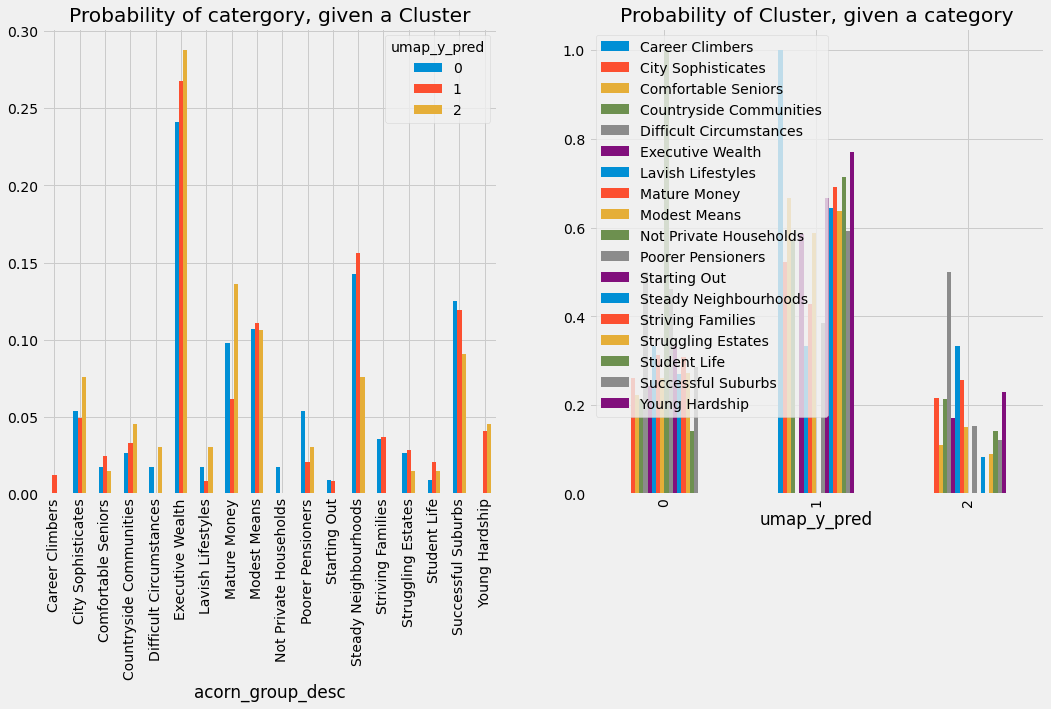

In [170]:
plot_acorn(tmp,'acorn_group_desc','umap_y_pred')

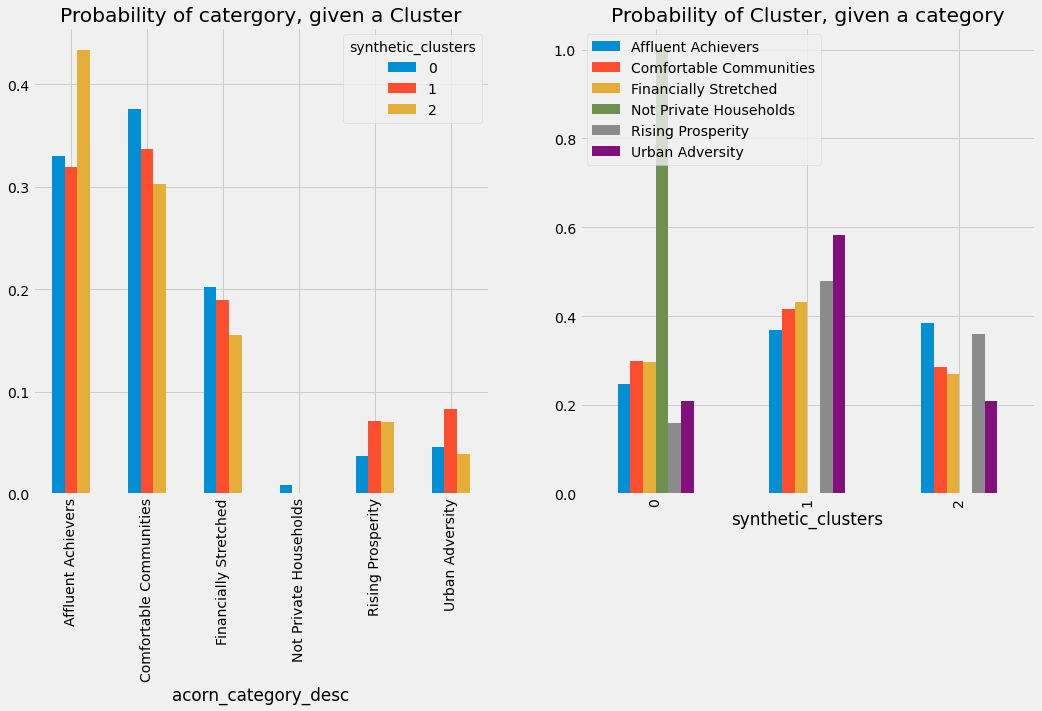

In [95]:
plot_acorn(tmp,'acorn_category_desc','synthetic_clusters')

### Summary:
- Group 0: distinctively not private households who are likely to be comfortable communities
- Group 1: more towards steady neighbourhood, executive wealth, successful suburbs with modest means.Career climbers with young hardship and struggling estate also fall into this group. In short, they are most likely to be urban adversity 
- Group 2: more towards difficult circumstances, student life and executive wealth. In short, they are affluent achievers


## RFM vs Synthetic Clustering

In [171]:
data=data.merge(rfm,left_on=['partner_position_id'],right_on=['partner_position_id'],how='left')

In [172]:
rfm_columns=['partner_position_id', 'recency_score', 'frequency_score',
       'value_score',  'rfm_score', 'dormant',
       'semi_dormant', 'engaged', 'engagement','umap_y_pred']

In [173]:
tmp=data[rfm_columns]

In [174]:
a=tmp.groupby(['umap_y_pred'])['rfm_score'].mean().reset_index().rename(columns={'rfm_score':'mean_rfm'}).set_index('umap_y_pred')
b=tmp.groupby(['umap_y_pred'])['rfm_score'].median().reset_index().rename(columns={'rfm_score':'median_rfm'}).set_index('umap_y_pred')

In [175]:
pd.concat([a,b],axis=1)

,mean_rfm,median_rfm
umap_y_pred,,
0,11.918033,13
1,11.654902,13
2,11.774648,13


<AxesSubplot:title={'center':'RFM Score per Cluster'}, xlabel='umap_y_pred'>

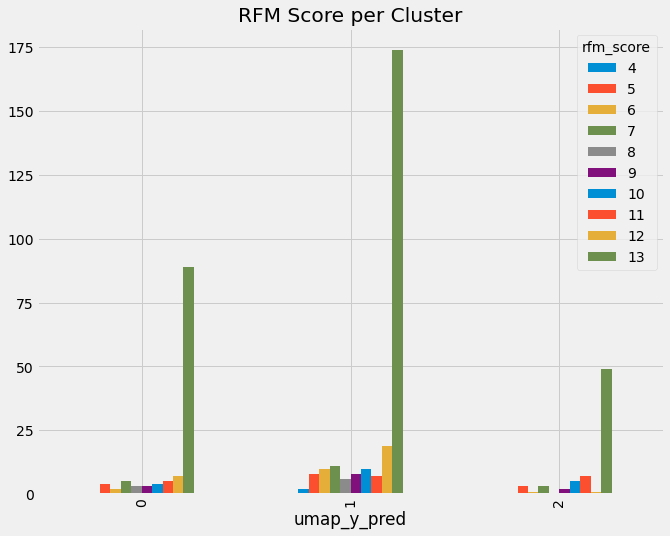

In [176]:
f,ax=plt.subplots(figsize=(10,8))
pd.crosstab(tmp.umap_y_pred,tmp.rfm_score).plot(kind='bar',title='RFM Score per Cluster',ax=ax)

<AxesSubplot:title={'center':'RFM Score per Cluster'}, xlabel='synthetic_clusters'>

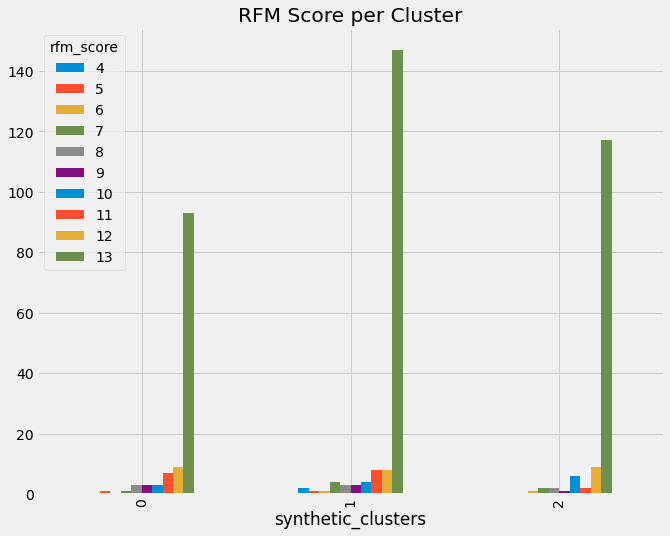

In [37]:
f,ax=plt.subplots(figsize=(10,8))
pd.crosstab(tmp.synthetic_clusters,tmp.rfm_score).plot(kind='bar',title='RFM Score per Cluster',ax=ax)

### All Live Partners

In [146]:
all_live_df=all_live_df.merge(rfm,left_on=['partner_position_id'],right_on=['partner_position_id'],how='left')

In [147]:
all_live_df.columns

Index(['partner_position_id', 'articles_unique_days_viewed_last_1m',
       'customers_gathered_last_1m', 'avg_monthly_ri_earned_last_3m',
       'days_logged_into_portal_last_1m', 'days_logged_into_portal_last_3m',
       'days_since_last_activity', 'jtc_applications_last_1m',
       'jtc_applications_last_3m', 'learning_plans_started_last_1m',
       'prospects_unique_days_viewed_last_1m',
       'times_successfully_supporting_last_1m', 'tenure_months',
       'recency_score', 'frequency_score', 'value_score', 'rfm_score',
       'dormant', 'semi_dormant', 'engaged', 'engagement', 'rfm_category'],
      dtype='object')

In [148]:
tmp=all_live_df[['rfm_score','days_logged_into_portal_last_3m',
  'articles_unique_days_viewed_last_1m',
 'prospects_unique_days_viewed_last_1m',
  'jtc_applications_last_3m'
 ]]

In [149]:
tmp[tmp.rfm_score>=12].mean()

rfm_score                               12.681287
days_logged_into_portal_last_3m         40.384706
articles_unique_days_viewed_last_1m      0.000000
prospects_unique_days_viewed_last_1m     0.000000
jtc_applications_last_3m                14.475854
dtype: float64